In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import statistics
import itertools

In [3]:
# Fungsi Plot Gambar di Jupiter
def plot_images(*imgs, figsize=(30,20), hide_ticks=False):
    f = plt.figure(figsize=figsize)
    width = np.ceil(np.sqrt(len(imgs)))
    height = np.ceil(len(imgs) / width)
    for i, img in enumerate(imgs, 1):
        ax = f.add_subplot(int(height), int(width), i)
        if hide_ticks:
            ax.axis('off')
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [4]:
# Fungsi Hamming Distance
def hamming_distance(vector1, vector2):
    # Pastikan kedua vektor memiliki panjang yang sama
    assert len(vector1) == len(vector2), "Panjang vektor harus sama"

    # Hitung Hamming distance
    distance = sum(bit1 != bit2 for bit1, bit2 in zip(vector1, vector2))
    
    return distance

In [5]:
def jarak(vector1, vector2):
    return ((vector1[0]-vector2[0])**2 + (vector1[1]-vector2[1])**2)**0.5

In [6]:
def angle_between_vectors(v1, v2):
    dot_product = np.dot(v1, v2)
    cross_product = np.cross(v1, v2)
    
    # Hitung sudut antara dua vektor
    angle = np.arctan2(np.linalg.norm(cross_product), dot_product)
    
    # Tentukan arahnya (clockwise atau counter-clockwise)
    direction = np.sign(cross_product)
    
    return np.degrees(angle), direction

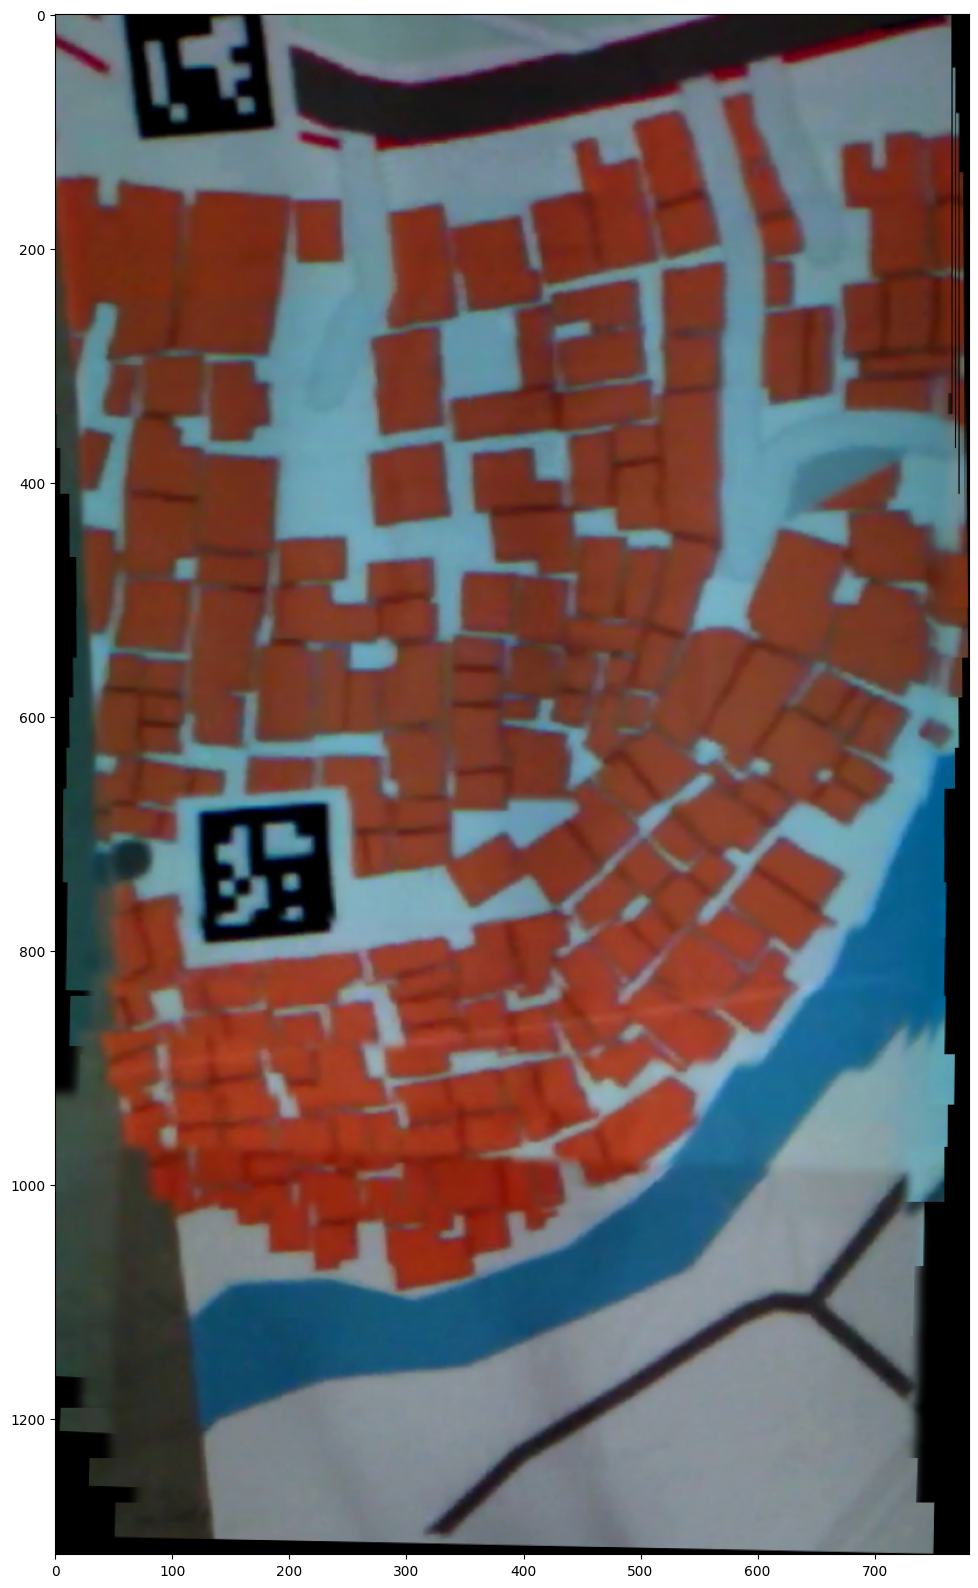

In [52]:
# ********* Insert Image *********
image_paths = glob.glob('AmbilData7/*.jpg')
imgs = []
n = len(image_paths)
n = 24

# ********* Kernel Pre-Processing *********
kernel_contras = np.array([[-1, -1, -1],
                [-1, 9, -1],
                [-1, -1, -1]])
kernel_sharp = np.array([[0, -1, 0],
                [-1, 5, -1],
                [0, -1, 0]])

# ********* Matriks Kalibrasi Kamera *********
mtx1 = np.array([[682.84055098,   0.,         308.47833431],
 [  0.,         683.17356074, 184.14295734],
 [  0.,           0.,           1.        ]])
dist1 = np.array([-0.02243873,  0.10428033, -0.00261665, -0.00163101, -0.19535318])
newcameramtx1 = np.array([[680.79500661,   0.,         307.68874874],
 [  0.,         681.03835398, 183.55170193],
 [  0.,           0.,           1.        ]])
roi1 = [1, 1, 638, 278]

# ********* Save Image in Var *********
for i in range(n):
    img = cv2.imread(image_paths[i])
    # Calibrating
    img = cv2.undistort(img, mtx1, dist1, None, newcameramtx1)
    x, y, w, h = roi1
    img = img[y:y+h, x:x+w]
    # Resizing
    img = cv2.resize(img,None,fx=1.2,fy=1.2)
    # Rotating
    img = cv2.rotate(img, cv2.ROTATE_180)

    imgs.append(img)

# ********* Pre-Processing Left *********
pref = imgs[0]
pref_gray = cv2.cvtColor(pref, cv2.COLOR_BGR2GRAY)
pref_pp = cv2.convertScaleAbs(pref_gray, alpha=1.5, beta=7)
# pref_pp = cv2.filter2D(pref_pp, -1, kernel_sharp)

# ********* Menyamakan Intensitas *********
if pref_pp.any() < 80:
    for k in range(pref_pp.shape[0]):
        for l in range(pref_pp.shape[1]):
            if pref_pp[k,l] < 80:
                pref_pp[k,l] = random.randint(80, 100)

# ********* Deklarasi Metode *********
orb = cv2.ORB_create(nfeatures=50, scaleFactor=1.2, nlevels=8, edgeThreshold=10, firstLevel=0, WTA_K=2, scoreType=1, patchSize=31, fastThreshold=20)

# ********* Mask *********
mask_top_left = np.zeros_like(pref_gray, dtype=np.uint8)
mask_top_left[:pref_gray.shape[0]//2+20, :pref_gray.shape[1]//2+20] = 255

mask_top_right = np.zeros_like(pref_gray, dtype=np.uint8)
mask_top_right[:pref_gray.shape[0]//2+20, pref_gray.shape[1]//2-20:] = 255

mask_bottom_left = np.zeros_like(pref_gray, dtype=np.uint8)
mask_bottom_left[pref_gray.shape[0]//2-20:, :pref_gray.shape[1]//2+20] = 255

mask_bottom_right = np.zeros_like(pref_gray, dtype=np.uint8)
mask_bottom_right[pref_gray.shape[0]//2-20:, pref_gray.shape[1]//2-20:] = 255

# ********* Ekstraksi Fitur *********
kp_pref_tl, des_pref_tl = orb.detectAndCompute(pref_pp, mask_top_left)
kp_pref_tr, des_pref_tr = orb.detectAndCompute(pref_pp, mask_top_right)
kp_pref_bl, des_pref_bl = orb.detectAndCompute(pref_pp, mask_bottom_left)
kp_pref_br, des_pref_br = orb.detectAndCompute(pref_pp, mask_bottom_right)

kp_pref = kp_pref_tl + kp_pref_tr + kp_pref_bl + kp_pref_br
des_pref = np.vstack((des_pref_tl, des_pref_tr, des_pref_bl, des_pref_br))

# ********* Buang Fitur Berdempetan *********
kp_p_f = []
des_p_f = []
responses = []
for idx1, kp in enumerate(kp_pref):
    x, y = kp.pt
    idx2 = -1
    for idx2 in range(len(kp_p_f)):
        if jarak((x,y), kp_p_f[idx2]) < 10: # Adjustable
            if responses[idx2] < kp.response:
                des_p_f[idx2] = des_pref[idx1,:]
                kp_p_f[idx2] = (x,y)
                responses[idx2] = kp.response
            idx2 -= 1
            break
    if idx2 == len(kp_p_f)-1:
        des_p_f.append(des_pref[idx1,:])
        kp_p_f.append((x,y))
        responses.append(kp.response)
des_p_f = np.array(des_p_f)
kp_p_f = np.array(kp_p_f).astype(int)

# ********* Matriks Transformasi *********
TM = []

# ********* Loop Feature Detection - Get Transformation Matrix *********
for i in range(1,n):
    left = pref
    left_gray = pref_gray
    left_pp = pref_pp

    kp_left = kp_pref
    des_left = des_pref
    des_l_f = des_p_f
    kp_l_f = kp_p_f

    # ********* Pre-Processing Right *********
    right = imgs[i]
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    right_pp = cv2.convertScaleAbs(right_gray, alpha=1.5, beta=7)
    # right_pp = cv2.filter2D(right_pp, -1, kernel_sharp)

    # ********* Menyamakan Intensitas *********
    if right_pp.any() < 80:
        for k in range(right_pp.shape[0]):
            for l in range(right_pp.shape[1]):
                if right_pp[k,l] < 80:
                    right_pp[k,l] = random.randint(80, 100)


    # ********* Ekstraksi Fitur *********
    kp_right_tl, des_right_tl = orb.detectAndCompute(right_pp, mask_top_left)
    kp_right_tr, des_right_tr = orb.detectAndCompute(right_pp, mask_top_right)
    kp_right_bl, des_right_bl = orb.detectAndCompute(right_pp, mask_bottom_left)
    kp_right_br, des_right_br = orb.detectAndCompute(right_pp, mask_bottom_right)

    kp_right = ()
    des_right = np.array([])
    for var in [kp_right_tl, kp_right_tr, kp_right_bl, kp_right_br]:
        if var:
            kp_right += var
    for var in [des_right_tl, des_right_tr, des_right_bl, des_right_br]:
        if var is not None:
            if des_right.size == 0:
                des_right = var
            else:
                des_right = np.vstack((des_right, var))

    # # ********* Gambar KeyPoint *********
    # keypoints_drawn_left = cv2.drawKeypoints(left, kp_left, None, color=(0, 255, 0))
    # keypoints_drawn_right = cv2.drawKeypoints(right, kp_right, None, color=(0, 255, 0))
    # plot_images(keypoints_drawn_left, keypoints_drawn_right)

    # ********* Buang Fitur Berdempetan *********
    kp_r_f = []
    des_r_f = []
    responses = []
    for idx1, kp in enumerate(kp_right):
        x, y = kp.pt
        idx2 = -1
        for idx2 in range(len(kp_r_f)):
            if jarak((x,y), kp_r_f[idx2]) < 10: # Adjustable
                if responses[idx2] < kp.response:
                    des_r_f[idx2] = des_right[idx1,:]
                    kp_r_f[idx2] = (x, y)
                    responses[idx2] = kp.response
                idx2 -= 1
                break
        if idx2 == len(kp_r_f)-1:
            des_r_f.append(des_right[idx1,:])
            kp_r_f.append((x, y))
            responses.append(kp.response)
    des_r_f = np.array(des_r_f)
    kp_r_f = np.array(kp_r_f).astype(int)
    
    # # ********* Gambar Filtered KeyPoint *********
    # left_draw_kp = pref
    # right_draw_kp = imgs[i]
    # for point in kp_l_f:
    #     cv2.circle(left_draw_kp, point, 4, (0,255,0))
    # for point in kp_r_f:
    #     cv2.circle(right_draw_kp, point, 4, (0,255,0))
    # # lr_draw_kp = cv2.addWeighted(left_draw_kp, 0.5, right_draw_kp, 0.5, 0)
    # plot_images(left_draw_kp,right_draw_kp)
    # # plot_images(left_pp)

    # ********* Pencocokan Fitur MN *********
    pt_mat = []
    dis_mat = []
    for idx1 in range(len(kp_l_f)):
        xl, yl = kp_l_f[idx1]
        d_best = float('inf')
        for idx2 in range(len(kp_r_f)):
            xr, yr = kp_r_f[idx2]
            if jarak((xr,yr),(xl,yl)) < 80:
                d = hamming_distance(des_l_f[idx1], des_r_f[idx2])
                if d < d_best:
                    d_best = d
                    idx = idx2
        if d_best < 31:
            pt_mat.append((kp_l_f[idx1][0],kp_l_f[idx1][1],kp_r_f[idx][0],kp_r_f[idx][1]))
            dis_mat.append(d_best)
            
    # # ********* Gambar Matches & Hitung Jarak *********
    # for k in range(len(pt_mat)):
    #     img_con = np.concatenate((left, right), axis=1)
    #     for x1, y1, x2, y2 in pt_mat[k:k+1]:
    #         cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #         cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    #         cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    #     plot_images(img_con)

    # img_con = np.concatenate((left, right), axis=1)
    # dis_pos = []
    # for x1, y1, x2, y2 in pt_mat:
    #     dis_pos.append(jarak((x1,y1), (x2,y2)))
    #     cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #     cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    #     cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    # plot_images(img_con)
    # print(dis_mat)
    # print(dis_pos)

    # # ********* Miss Match Removing - Berdasarkan Jarak *********
    # rounded_dis_pos = [round(num, -1) for num in dis_pos]
    # modus = statistics.mode(rounded_dis_pos)
    # pt_mat_df = []
    # dis_mat_df = []
    # for k in range(len(pt_mat)):
    #     if rounded_dis_pos[k] == modus:
    #         pt_mat_df.append(pt_mat[k])
    #         dis_mat_df.append(dis_mat[k])
    # if len(pt_mat_df) < 2:
    #     pt_mat_df = pt_mat
    #     dis_mat_df = dis_mat
    # # print(pt_mat_df)
    # # print(dis_mat_df)

    # ********* Miss Match Removing - Berdasarkan Hamming Distance *********
    sorted_combined = sorted(zip(dis_mat, pt_mat))
    limit = 5
    sorted_dis, sorted_pt = zip(*sorted_combined[:limit])

    # # ********* Gambar Best Matches *********
    # img_con = np.concatenate((left, right), axis=1)
    # for x1, y1, x2, y2 in sorted_pt:
    #     cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #     cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    #     cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    # plot_images(img_con)

    # ********* Cari Matriks Transformasi Terbaik *********
    kombinasi = list(itertools.combinations(sorted_pt, 2))
    Merr = float('inf')
    for k in range(len(kombinasi)):
        x1, y1, x2, y2 = kombinasi[k][0]
        x3, y3, x4, y4 = kombinasi[k][1]
        # Translasi
        tx = ((x1 - x2)+(x3 - x4))/2
        ty = ((y1 - y2)+(y3 - y4))/2
        T1 = np.array([[1, 0, tx],
                [0, 1, ty],
                [0, 0, 1]])
        # Rotasi
        v1 = (x3-x1, y3-y1)
        v2 = (x4-x2, y4-y2)
        theta, direction = angle_between_vectors(v1, v2) 
        theta = theta*direction
        perbesaran = np.linalg.norm(v1)/np.linalg.norm(v2)
        T2 = cv2.getRotationMatrix2D((float(x2+tx),float(y2+ty)), theta, perbesaran)
        MT = np.dot(T2,T1)
        # Error
        err = 0
        for x1, y1, x2, y2 in sorted_pt:
            x3, y3 = np.dot(MT,[x2,y2,1])
            err += jarak((x1,y1),(x3,y3))
        if err < Merr:
            Merr = err
            M = MT

    # Simpan Matriks Transformasi
    if i == 1:
        TM.append(M)
        TM = np.array(TM)
    else:
        M1 = np.vstack((TM[i-2], [0, 0, 1]))
        M = np.dot(M,M1)
        TM = np.append(TM, [M], axis=0)

    # Simpan Gambar Kanan Untuk Kiri
    pref = right
    pref_gray = right_gray
    pref_pp = right_pp

    kp_pref = kp_right
    des_pref = des_right
    des_p_f = des_r_f
    kp_p_f = kp_r_f

# ********* Loop Image Registration *********
pref = imgs[0]
for i in range(1,n):
    left = pref
    left_gray = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
    right = imgs[i]
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    right_pp = cv2.convertScaleAbs(right_gray, alpha=1.5, beta=7)
    # ********* Menyamakan Intensitas *********
    if right_pp.any() < 80:
        for k in range(right_pp.shape[0]):
            for l in range(right_pp.shape[1]):
                if right_pp[k,l] < 80:
                    right_pp[k,l] = random.randint(80, 100)
    
    dim_x = left.shape[1] + right.shape[1]
    dim_y = left.shape[0] + right.shape[0]
    dim = (dim_x, dim_y)
    comb = cv2.warpAffine(right,TM[i-1],dim)
    comb_pp = cv2.warpAffine(right_pp,TM[i-1],dim)
    # plot_images(comb)

    # ********* Membuat Mask *********
    _, th = cv2.threshold(comb_pp, 1, 255, cv2.THRESH_BINARY)
    kernel = np.ones((35, 35), np.uint8)
    mask = cv2.erode(th, kernel, iterations=1)
    mask = cv2.GaussianBlur(mask, (25, 25), 0)
    # plot_images(mask)

    # ********* Jahit Citra *********
    for k in range(left.shape[0]-10):
        for l in range(left.shape[1]):
            alpha = mask[k,l]/255
            comb[k,l] = (1-alpha)*left[k,l] + alpha*comb[k,l]
            # if mask[k,l] == 0:
            #     comb[k,l] = left[k,l]
            # else:
            #     alpha_k = (left.shape[0]-k)/(left.shape[0])
            #     alpha_l = (left.shape[1]-l)/(left.shape[1])
            #     alpha = max(alpha_k,alpha_l)
            #     comb[k,l] = alpha*left[k,l] + (1-alpha)*comb[k,l]
    # ********* Crop *********
    comb_gray = cv2.cvtColor(comb, cv2.COLOR_BGR2GRAY)
    for j in range(int(dim_x/2),dim_x):
        if comb_gray[:,j].sum() == 0:
            x_crop = j
            break
        else:
            x_crop = dim_x
    for j in range(int(dim_y/2),dim_y):
        if comb_gray[j,:].sum() == 0:
            y_crop = j
            break
        else:
            y_crop = dim_y
    if y_crop == dim_y | x_crop == dim_x:
        print("Penjahitan Error!")
        break
    pref = comb[:y_crop, :x_crop]
plot_images(pref)


In [ ]:
v1 = [-1,0,1]
T = [[1, 0, 10], [0, 1, 9]]
print(np.dot(T,v1))

[9 9]


In [ ]:
import numpy as np



# Contoh dua vektor
vector1 = np.array([-1, 0])
vector2 = np.array([2, 2])

# Hitung sudut dan arahnya
angle, direction = angle_between_vectors(vector1, vector2)

print("Sudut antara dua vektor:", angle, "derajat")
print(direction)
if direction == 1:
    print("Arahnya adalah counter-clockwise")
else:
    print("Arahnya adalah clockwise")


Sudut antara dua vektor: 135.0 derajat
-1
Arahnya adalah clockwise


In [ ]:
# Insert Image
image_paths = glob.glob('AmbilData9/*.jpg')
imgs = []
n = len(image_paths)
n = 2

# Kernel Pre-Processing
kernel_contras = np.array([[-1, -1, -1],
                [-1, 9, -1],
                [-1, -1, -1]])
kernel_sharp = np.array([[0, -1, 0],
                [-1, 5, -1],
                [0, -1, 0]])

# Matriks Kalibrasi Kamera
mtx1 = np.array([[682.84055098,   0.,         308.47833431],
 [  0.,         683.17356074, 184.14295734],
 [  0.,           0.,           1.        ]])
dist1 = np.array([-0.02243873,  0.10428033, -0.00261665, -0.00163101, -0.19535318])
newcameramtx1 = np.array([[680.79500661,   0.,         307.68874874],
 [  0.,         681.03835398, 183.55170193],
 [  0.,           0.,           1.        ]])
roi1 = [1, 1, 638, 278]

# Save Image in Var
for i in range(n):
    img = cv2.imread(image_paths[i])
    # Calibrating
    img = cv2.undistort(img, mtx1, dist1, None, newcameramtx1)
    x, y, w, h = roi1
    img = img[y:y+h, x:x+w]
    # Resizing
    # img = cv2.resize(img,None,fx=1.2,fy=1.2)
    # Rotating
    img = cv2.rotate(img, cv2.ROTATE_180)

    imgs.append(img)

# Pre-Processing Left
pref = imgs[0]
pref_gray = cv2.cvtColor(pref, cv2.COLOR_BGR2GRAY)
pref_pp = cv2.convertScaleAbs(pref_gray, alpha=1.5, beta=7)
pref_pp = cv2.filter2D(pref_pp, -1, kernel_sharp)
# Menyamakan Intensitas
if pref_pp.any() < 80:
    for k in range(pref_pp.shape[0]):
        for l in range(pref_pp.shape[1]):
            if pref_pp[k,l] < 80:
                pref_pp[k,l] = random.randint(80, 100)

# Deklarasi Metode
orb = cv2.ORB_create(nfeatures=10, scaleFactor=1.2, nlevels=8, edgeThreshold=31, firstLevel=0, WTA_K=2, scoreType=1, patchSize=40, fastThreshold=15)

# Ekstraksi Fitur
kp_pref, des_pref = orb.detectAndCompute(pref_pp, None)
# # ********* Buang Fitur Berdempetan *********
# kp_p_f = []
# des_p_f = []
# for idx1, kp in enumerate(kp_pref):
#     x, y = kp.pt
#     idx2 = -1
#     for idx2 in range(len(kp_p_f)):
#         if  jarak((x,y),kp_p_f[idx2])< 10:
#             idx2 -= 1
#             break
#     if idx2 == len(kp_p_f)-1:
#         des_p_f.append(des_pref[idx1])
#         kp_p_f.append((x, y))
# des_p_f = np.array(des_p_f)
# kp_p_f = np.array(kp_p_f).astype(int)

# Matriks Transformasi
TM = []

# Loop Feature Detection - Get Transformation Matrix
for i in range(1,n):

    left = pref
    left_gray = pref_gray
    left_pp = pref_pp

    kp_left = kp_pref
    des_left = des_pref
    # des_l_f = des_p_f
    # kp_l_f = kp_p_f

    # Pre-Processing Right
    right = imgs[i]
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    right_pp = cv2.convertScaleAbs(right_gray, alpha=1.5, beta=7)
    right_pp = cv2.filter2D(right_pp, -1, kernel_sharp)

    # Menyamakan Intensitas
    if right_pp.any() < 80:
        for k in range(right_pp.shape[0]):
            for l in range(right_pp.shape[1]):
                if right_pp[k,l] < 80:
                    right_pp[k,l] = random.randint(80, 100)


    # Ekstraksi Fitur
    kp_right, des_right = orb.detectAndCompute(right_pp, None)

    # Gambar KeyPoint
    keypoints_drawn_left = cv2.drawKeypoints(left, kp_left, None, color=(0, 255, 0))
    keypoints_drawn_right = cv2.drawKeypoints(right, kp_right, None, color=(0, 255, 0))
    plot_images(keypoints_drawn_left, keypoints_drawn_right)

    # # ********* Buang Fitur Berdempetan *********
    # kp_r_f = []
    # des_r_f = []
    # responses = []
    # for idx1, kp in enumerate(kp_right):
    #     x, y = kp.pt
    #     idx2 = -1
    #     for idx2 in range(len(kp_r_f)):
    #         if jarak((x,y), kp_r_f[idx2]) < 10:
    #             if responses[idx2] < kp.response:
    #                 des_r_f[idx2] = des_right[idx1,:]
    #                 kp_r_f[idx2] = (x, y)
    #                 responses[idx2] = kp.response
    #             idx2 -= 1
    #             break
    #     if idx2 == len(kp_r_f)-1:
    #         des_r_f.append(des_right[idx1,:])
    #         kp_r_f.append((x, y))
    #         responses.append(kp.response)
    # des_r_f = np.array(des_r_f)
    # kp_r_f = np.array(kp_r_f).astype(int)
    
    # # ********* Gambar Filtered KeyPoint *********
    # left_draw_kp = pref
    # right_draw_kp = imgs[i]
    # for point in kp_l_f:
    #     cv2.circle(left_draw_kp, point, 4, (0,255,0))
    # for point in kp_r_f:
    #     cv2.circle(right_draw_kp, point, 4, (0,255,0))
    # # lr_draw_kp = cv2.addWeighted(left_draw_kp, 0.5, right_draw_kp, 0.5, 0)
    # plot_images(left_draw_kp,right_draw_kp)
    # # plot_images(left_pp)

    # ========= Pencocokan Fitur BF ==========
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des_left,des_right)
    
    # matches_drawn = cv2.drawMatches(left, kp_left, right, kp_right, matches, None, matchColor=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    # plot_images(matches_drawn)

    # ========= Caru Best Pencocokan Fitur BF ==========
    limit = 5
    best = sorted(matches, key = lambda x:x.distance)[:limit]

    # best_matches_drawn = cv2.drawMatches(left, kp_left, right, kp_right, best, None, matchColor=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    # plot_images(best_matches_drawn)

    # ========= Membuat List KP ==========
    left_pts = []
    right_pts = []
    for m in best:
        l = kp_left[m.queryIdx].pt
        r = kp_right[m.trainIdx].pt
        left_pts.append(l)
        right_pts.append(r)

    # ========= Miss Match Jarak ==========
    dis_pos = []
    for idx in range(limit):
        dis_pos.append(jarak(left_pts[idx],right_pts[idx]))
    sorted_combined = sorted(zip(dis_pos, left_pts, right_pts))
    limit = 2
    sorted_dis, sorted_pt_left, sorted_pt_right = zip(*sorted_combined[:limit])
    print(sorted_dis)

    img_con = np.concatenate((left, right), axis=1)
    for idx in range(limit):
        x1, y1 = sorted_pt_left[idx]
        x1 = int(x1)
        y1 = int(y1)
        x2, y2 = sorted_pt_right[idx]
        x2 = int(x2)
        y2 = int(y2)
        cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
        cv2.circle(img_con, (x1, y1), 4, (0,255,0))
        cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    plot_images(img_con)

    # # ********* Pencocokan Fitur MN *********
    # pt_mat = []
    # dis_mat = []
    # for idx1 in range(len(kp_l_f)):
    #     xl, yl = kp_l_f[idx1]
    #     idx_mat = []
    #     for idx2 in range(len(kp_r_f)):
    #         xr, yr = kp_r_f[idx2]
    #         if jarak((xr,yr),(xl,yl)) < 60:
    #             idx_mat.append(idx2)
    #     d_best = float('inf')
    #     for idx2 in idx_mat:
    #         d = hamming_distance(des_l_f[idx1], des_r_f[idx2])
    #         # Matching
    #         if d < d_best:
    #             d_best = d
    #             idx = idx2
    #     if d_best < 31:
    #         pt_mat.append((kp_l_f[idx1][0],kp_l_f[idx1][1],kp_r_f[idx][0],kp_r_f[idx][1]))
    #         dis_mat.append(d_best)
            
    # # ********* Gambar Matches *********
    # # for k in range(len(pt_mat)):
    # #     img_con = np.concatenate((left, right), axis=1)
    # #     for x1, y1, x2, y2 in pt_mat[k:k+1]:
    # #         cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    # #         cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    # #         cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    # #     plot_images(img_con)

    # img_con = np.concatenate((left, right), axis=1)
    # dis_pos = []
    # for x1, y1, x2, y2 in pt_mat:
    #     dis_pos.append(jarak((x1,y1), (x2,y2)))
    # #     cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    # #     cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    # #     cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    # # plot_images(img_con)


    # # ********* Miss Match Removing - Berdasarkan Jarak *********
    # rounded_dis_pos = [round(num, -1) for num in dis_pos]
    # # print(pt_mat)
    # # print(dis_mat)
    # # print(dis_pos)
    # modus = statistics.mode(rounded_dis_pos)
    # pt_mat_df = []
    # dis_mat_df = []
    # for k in range(len(pt_mat)):
    #     if rounded_dis_pos[k] == modus:
    #         pt_mat_df.append(pt_mat[k])
    #         dis_mat_df.append(dis_mat[k])
    # if len(pt_mat_df) < 2:
    #     pt_mat_df = pt_mat
    #     dis_mat_df = dis_mat
    # # print(pt_mat_df)
    # # print(dis_mat_df)

    # # ********* Miss Match Removing - Berdasarkan Hamming Distance *********
    # sorted_combined = sorted(zip(dis_mat_df, pt_mat_df))
    # limit = 2
    # sorted_dis, sorted_pt = zip(*sorted_combined[:limit])
    # # print(sorted_pt)
    # # print(sorted_dis)

    # # ********* Gambar Best Matches *********
    # img_con = np.concatenate((left, right), axis=1)
    # for x1, y1, x2, y2 in sorted_pt:
    #     cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #     cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    #     cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    # plot_images(img_con)

    # # Cari Matriks Transformasi
    # x1, y1, x2, y2 = sorted_pt[0]
    # x3, y3, x4, y4 = sorted_pt[1]
    # # Translasi
    # tx = ((x1 - x2)+(x3 - x4))/2
    # ty = ((y1 - y2)+(y3 - y4))/2
    # T1 = np.array([[1, 0, tx],
    #            [0, 1, ty],
    #            [0, 0, 1]])
    # # Rotasi
    # v1 = (x3-x1, y3-y1)
    # v2 = (x4-x2, y4-y2)
    # dot_product = np.dot(v1, v2)
    # norm_a = np.linalg.norm(v1)
    # norm_b = np.linalg.norm(v2)
    # angle_radians = np.arccos(dot_product / (norm_a * norm_b))
    # theta = np.degrees(angle_radians) # Dalam derajat 
    # # print(theta)
    # # if theta < 5:
    # #     theta = 0 
    # T2 = cv2.getRotationMatrix2D((float(x2+tx),float(y2+ty)), theta, 1)
    # M = np.dot(T2,T1)
    # # pts_src = []
    # # pts_dst = []
    # # for x1, y1, x2, y2 in sorted_pt:
    # #     pts_dst.append([x1,y1])
    # #     pts_src.append([x2,y2])
    # # pts_src = np.array(pts_src)
    # # pts_dst = np.array(pts_dst)
    # # M = cv2.getAffineTransform(pts_src, pts_dst)
    # # print(T2)
    # print(M)

    # # Simpan Matriks Transformasi
    # if i == 1:
    #     TM.append(M)
    #     TM = np.array(TM)
    # else:
    #     M1 = np.vstack((TM[i-2], [0, 0, 1]))
    #     M = np.dot(M,M1)
    #     TM = np.append(TM, [M], axis=0)
    # # print(TM)

    # Simpan Gambar Kanan Untuk Kiri
    pref = right
    pref_gray = right_gray
    pref_pp = right_pp

    kp_pref = kp_right
    des_pref = des_right
    # des_p_f = des_r_f
    # kp_p_f = kp_r_f

# Loop Image Registration
# TM = np.array([[[0.99948837,0.03198437,-1.21282758], [-0.03198437,0.99948837,25.16608645]],
#               [[ 9.99926776e-01,  1.21013102e-02, -4.52066866e+00], [-1.21013102e-02,  9.99926776e-01,  2.14515328e+01]]])
pref = imgs[0]
for i in range(1,1):
    left = pref
    right = imgs[i]
    dim_x = left.shape[1] + right.shape[1]
    dim_y = left.shape[0] + right.shape[0]
    dim = (dim_x, dim_y)
    comb = cv2.warpAffine(right,TM[i-1],dim)
    # comb = cv2.addWeighted(left, 1, comb, 0.5, 0)
    comb_gray = cv2.cvtColor(comb, cv2.COLOR_BGR2GRAY)
    left_gray = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    # plot_images(comb)
    for k in range(left.shape[0]):
        for l in range(left.shape[1]):
            if k <= 0.15*left.shape[0] or l <= 0.1*left.shape[1]:
                comb[k,l] = left[k,l]
            else:
                alpha_k = (left.shape[0]-k)/(0.85*left.shape[0])
                alpha_l = (left.shape[1]-l)/(0.9*left.shape[1])
                alpha = min(alpha_k,alpha_l)
                comb[k,l] = alpha*left[k,l] + (1-alpha)*comb[k,l]
    # Crop
    comb_gray = cv2.cvtColor(comb, cv2.COLOR_BGR2GRAY)
    for j in range(int(dim_x/2),dim_x):
        if comb_gray[:,j].sum() == 0:
            x_crop = j
            break
        else:
            x_crop = dim_x
    for j in range(int(dim_y/2),dim_y):
        if comb_gray[j,:].sum() == 0:
            y_crop = j
            break
        else:
            y_crop = dim_y
    if y_crop == dim_y | x_crop == dim_x:
        print("Penjahitan Error!")
        break
    pref = comb[:y_crop, :x_crop]

# plot_images(pref)

NameError: name 'none' is not defined

In [ ]:
    # # Buang Fitur di Area Hitam
    # kp_l_fh = []
    # des_l_fh = []
    # for idx1 in range(len(kp_l_f)):
    #     y, x = kp_l_f[idx1]
    #     if left_pp[x+3,y] > 37 & left_pp[x,y+3] > 37 & left_pp[x-3,y] > 37 & left_pp[x,y-3] > 37:
    #         kp_l_fh.append((x,y))
    #         des_l_fh.append(des_l_f[idx1,:])
    # des_l_f = np.array(des_l_fh)
    # kp_l_f = np.array(kp_l_fh)
    # kp_r_fh = []
    # des_r_fh = []
    # for idx1 in range(len(kp_r_f)):
    #     y, x = kp_r_f[idx1]
    #     if right_pp[x+3,y] > 37 & right_pp[x,y+3] > 37 & right_pp[x-3,y] > 37 & right_pp[x,y-3] > 37:
    #         kp_r_fh.append((x,y))
    #         des_r_fh.append(des_r_f[idx1,:])
    # des_r_f = np.array(des_r_fh)
    # kp_r_f = np.array(kp_r_fh)

In [ ]:
    # # ========= Pencocokan Fitur BF ==========
    # bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # matches = bf.match(des_left,des_right)
    
    # matches_drawn = cv2.drawMatches(left, kp_left, right, kp_right, matches, None, matchColor=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    # plot_images(matches_drawn)

    # # ========= Caru Best Pencocokan Fitur BF ==========
    # limit = 2
    # best = sorted(matches, key = lambda x:x.distance)[:limit]

    # best_matches_drawn = cv2.drawMatches(left, kp_left, right, kp_right, best, None, matchColor=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    # plot_images(best_matches_drawn)

    # # ========= Membuat List KP ==========
    # left_pts = []
    # right_pts = []
    # for m in best:
    #     l = kp_left[m.queryIdx].pt
    #     r = kp_right[m.trainIdx].pt
    #     left_pts.append(l)
    #     right_pts.append(r)

    # # ========= Miss Match Jarak ==========
    # dis_pos = []
    # for idx in range(limit):
    #     dis_pos.append(jarak(left_pts[idx],right_pts[idx]))
    # sorted_combined = sorted(zip(dis_pos, left_pts, right_pts))
    # limit = 5
    # sorted_dis, sorted_pt_left, sorted_pt_right = zip(*sorted_combined[:limit])
    # print(sorted_dis)

    # img_con = np.concatenate((left, right), axis=1)
    # for idx in range(limit):
    #     x1, y1 = sorted_pt_left[idx]
    #     x1 = int(x1)
    #     y1 = int(y1)
    #     x2, y2 = sorted_pt_right[idx]
    #     x2 = int(x2)
    #     y2 = int(y2)
    #     cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #     cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    #     cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    # plot_images(img_con)

    # # ========= Homography =========
    # M, _ = cv2.findHomography(np.float32(right_pts), np.float32(left_pts))

    # dim_x = left.shape[1] + right.shape[1]
    # dim_y = left.shape[0] + right.shape[0]
    # dim = (dim_x, dim_y)

    # warped = cv2.warpPerspective(right, M, dim)

    # # plot_images(warped)

    # comb = warped.copy()
    # # combine the two images

In [ ]:
# import cv2
# import glob

# image_paths=glob.glob('AmbilData9/*.jpg')

# imgs = []


# for i in range(10):
# 	imgs.append(cv2.imread(image_paths[i]))
# 	imgs[i] = cv2.rotate(imgs[i], cv2.ROTATE_180)



# stitchy=cv2.Stitcher.create()
# (dummy,output1)=stitchy.stitch(imgs)
# # cv2.imwrite('finalresult2.jpg',output1)

# if dummy != cv2.STITCHER_OK:
# 	print("stitching ain't successful")
# else:
# 	print('Your Panorama is ready!!!')

# plot_images(output1)

In [ ]:
import cv2

def select_best_keypoint(image_path):
    # Baca citra
    image = cv2.imread(image_path)
    
    # Ubah citra ke dalam skala keabuan
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Inisialisasi detektor FAST
    fast = cv2.FastFeatureDetector_create()
    
    # Deteksi fitur
    keypoints = fast.detect(gray, None)
    
    # Pilih keypoint terbaik berdasarkan responsivitas
    best_keypoint = max(keypoints, key=lambda kp: kp.response)
    
    return best_keypoint

# Panggil fungsi untuk memilih keypoint terbaik
best_keypoint = select_best_keypoint('AmbilData9/00001.jpg')
print("Koordinat keypoint terbaik:", best_keypoint.pt)
print("Responsivitas keypoint terbaik:", best_keypoint.response)


Koordinat keypoint terbaik: (561.0, 204.0)
Responsivitas keypoint terbaik: 65.0
